In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pybamm
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

print(pybamm.__version__)
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 15

24.9.0


In [2]:
import pickle
with open("cal_aging_results_200days.pkl", "rb") as file:
    data = pickle.load(file)
    
input_grid = np.array(data["input"]) # amb T, SOC
output_grid = np.array(data["output"]) # time_h, Q_loss
exp_count = 6 # 실험 몇개 있는 걸로 할지

In [3]:
with open('ECM_cal_Ea.pkl', 'rb') as f:
    Ea_save = pickle.load(f)
with open('ECM_cal_B.pkl', 'rb') as f:
    interp_func1 = pickle.load(f)
with open('ECM_cal_z.pkl', 'rb') as f:
    z_save = pickle.load(f)  

In [5]:
print(interp_func1([[0.05,0.2,0.4,0.6,0.8,1.0]]))
print(Ea_save)
print(z_save)

[[6.59348365e-06 2.31771825e-05 5.21893698e-05 5.37322317e-05
  8.99554270e-05 9.01643070e-05]]
17109.951135912983
0.9578175354222238


In [4]:
input_grid = np.array(data["input"]) # amb T, SOC
output_grid = np.array(data["output"]) # time_h, Q_loss

val_idx = [3,4,5,9,10,11,15,16,17,21,22,23,27,28,29]
val_idx = np.arange(len(input_grid))
input_val = input_grid[val_idx]
output_val = output_grid[val_idx]

temperature_K_candi = list(sorted(set(np.array(input_val)[:,0]+ 273.15)))
SOC_candi = list(sorted(set(np.array(input_val)[:,1])))
                
print(temperature_K_candi)
print(SOC_candi)

[288.15, 298.15, 308.15]
[0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99999]


In [5]:
x_models = []
y_exps = []
Temps = []
for i in range(len(val_idx)):
    index = val_idx[i]
    time_h = output_grid[index][0]    
    exp_indices = np.linspace(0,len(time_h)-1, exp_count, dtype=int)
    x_temp = time_h[exp_indices]*3600 # in seconds
    x_models.append(x_temp)
    
    y_temp = np.array(output_grid[index][1])[exp_indices]    
    y_exps.append(y_temp)
    
    Temps.append(input_grid[index][0]+273.15)

In [6]:
def y_model(params,time,Temp):
    y_temp = params[0]*np.exp(-params[1]/8.314/Temp)*time**params[2]
    return y_temp

In [7]:
for s, SOC in enumerate(SOC_candi):
    print(SOC)
    fitted_params = [interp_func1(SOC),Ea_save,z_save]
    fitted_params = np.array(fitted_params).flatten()
    
    x_model_T1 = x_models[3*s]
    x_model_T2 = x_models[3*s+1]
    x_model_T3 = x_models[3*s+2]
    y_exp_T1 = y_exps[3*s]
    y_exp_T2 = y_exps[3*s+1]
    y_exp_T3 = y_exps[3*s+2]
    
    def obj_func(fitted_params):
        y_model_T1 = y_model(fitted_params,x_model_T1,temperature_K_candi[0])
        y_model_T2 = y_model(fitted_params,x_model_T2,temperature_K_candi[1])
        y_model_T3 = y_model(fitted_params,x_model_T3,temperature_K_candi[2])
        rmse_T1 = np.sqrt(mean_squared_error(y_exp_T1, y_model_T1))
        rmse_T2 = np.sqrt(mean_squared_error(y_exp_T2, y_model_T2))
        rmse_T3 = np.sqrt(mean_squared_error(y_exp_T3, y_model_T3))
        rmse = np.mean([rmse_T1,rmse_T2,rmse_T3])
        return rmse


    y_plot_T1 = y_model(fitted_params,x_model_T1,temperature_K_candi[0])
    y_plot_T2 = y_model(fitted_params,x_model_T2,temperature_K_candi[1])
    y_plot_T3 = y_model(fitted_params,x_model_T3,temperature_K_candi[2])

    print('Fitted parameters: ',fitted_params)
    print(f"RMSE: {obj_func(fitted_params)}")
#     plt.figure(1,figsize=(8,4))
#     plt.grid()
#     plt.scatter(x_model_T1/3600/24, y_exp_T1,c='r',label='EM (15 °C)')
#     plt.plot(x_model_T1/3600/24,y_plot_T1,c='r',label='model (15 °C)')
#     plt.scatter(x_model_T2/3600/24, y_exp_T2,c='g',label='EM (25 °C)')
#     plt.plot(x_model_T2/3600/24,y_plot_T2,c='g',label='model (25 °C)')
#     plt.scatter(x_model_T3/3600/24, y_exp_T3,c='b',label='EM (35 °C)')
#     plt.plot(x_model_T3/3600/24,y_plot_T3,c='b',label='model (35 °C)')
#     plt.legend()
#     plt.title(f'SOC: {SOC}')
#     plt.xlabel('Time [days]')
#     plt.ylabel('Calendar aging loss [A.h]')
#     plt.legend(ncol=3,fontsize=10)
#     plt.show()

0.05
Fitted parameters:  [6.59348365e-06 1.71099511e+04 9.57817535e-01]
RMSE: 0.0012988844823708342
0.1
Fitted parameters:  [1.21213833e-05 1.71099511e+04 9.57817535e-01]
RMSE: 0.0016297098625522137
0.2
Fitted parameters:  [2.31771825e-05 1.71099511e+04 9.57817535e-01]
RMSE: 0.0051446940928195056
0.3
Fitted parameters:  [3.76832761e-05 1.71099511e+04 9.57817535e-01]
RMSE: 0.04522497956796948
0.4
Fitted parameters:  [5.21893698e-05 1.71099511e+04 9.57817535e-01]
RMSE: 0.003802641226013675
0.5
Fitted parameters:  [5.29608007e-05 1.71099511e+04 9.57817535e-01]
RMSE: 0.005559535010922105
0.6
Fitted parameters:  [5.37322317e-05 1.71099511e+04 9.57817535e-01]
RMSE: 0.003145222267653304
0.7
Fitted parameters:  [7.18438294e-05 1.71099511e+04 9.57817535e-01]
RMSE: 0.04300316017075378
0.8
Fitted parameters:  [8.99554270e-05 1.71099511e+04 9.57817535e-01]
RMSE: 0.01223595894290356
0.9
Fitted parameters:  [9.00598670e-05 1.71099511e+04 9.57817535e-01]
RMSE: 0.009925408718343591
0.99999
Fitted para

### Plotting for paper

In [8]:
input_grid = np.array(data["input"]) # amb T, SOC
output_grid = np.array(data["output"]) # time_h, Q_loss

val_idx = [3,4,5,15,16,17,27,28,29]
# val_idx = np.arange(len(input_grid))
input_val = input_grid[val_idx]
output_val = output_grid[val_idx]

temperature_K_candi = list(sorted(set(np.array(input_val)[:,0]+ 273.15)))
SOC_candi = list(sorted(set(np.array(input_val)[:,1])))
                
print(temperature_K_candi)
print(SOC_candi)

[288.15, 298.15, 308.15]
[0.1, 0.5, 0.9]


In [9]:
x_models = []
y_exps = []
Temps = []
for i in range(len(val_idx)):
    index = val_idx[i]
    time_h = output_grid[index][0]    
    exp_indices = np.linspace(0,len(time_h)-1, exp_count, dtype=int)
    x_temp = time_h[exp_indices]*3600 # in seconds
    x_models.append(x_temp)
    
    y_temp = np.array(output_grid[index][1])[exp_indices]    
    y_exps.append(y_temp)
    
    Temps.append(input_grid[index][0]+273.15)

In [10]:
def y_model(params,time,Temp):
    y_temp = params[0]*np.exp(-params[1]/8.314/Temp)*time**params[2]
    return y_temp

0.1
Fitted parameters:  [1.21213833e-05 1.71099511e+04 9.57817535e-01]
RMSE: 0.0016297098625522137
0.5
Fitted parameters:  [5.29608007e-05 1.71099511e+04 9.57817535e-01]
RMSE: 0.005559535010922105
0.9
Fitted parameters:  [9.00598670e-05 1.71099511e+04 9.57817535e-01]
RMSE: 0.009925408718343591


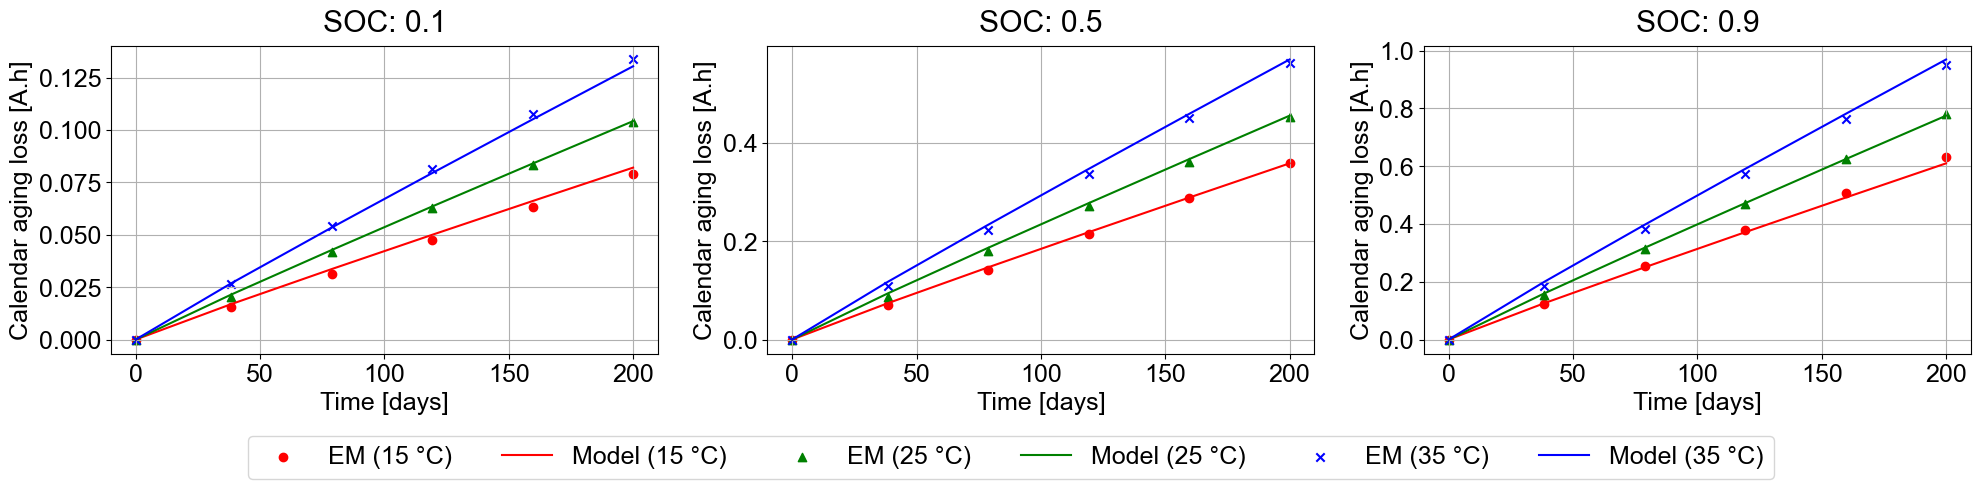

In [11]:
plt.rcParams['font.size'] = 18
SOC_candi = [0.1,0.5,0.9]
for s, SOC in enumerate(SOC_candi):
    print(SOC)
    fitted_params = [interp_func1(SOC),Ea_save,z_save]
    fitted_params = np.array(fitted_params).flatten()
    
    x_model_T1 = x_models[3*s]
    x_model_T2 = x_models[3*s+1]
    x_model_T3 = x_models[3*s+2]
    y_exp_T1 = y_exps[3*s]
    y_exp_T2 = y_exps[3*s+1]
    y_exp_T3 = y_exps[3*s+2]
    
    def obj_func(fitted_params):
        y_model_T1 = y_model(fitted_params,x_model_T1,temperature_K_candi[0])
        y_model_T2 = y_model(fitted_params,x_model_T2,temperature_K_candi[1])
        y_model_T3 = y_model(fitted_params,x_model_T3,temperature_K_candi[2])
        rmse_T1 = np.sqrt(mean_squared_error(y_exp_T1, y_model_T1))
        rmse_T2 = np.sqrt(mean_squared_error(y_exp_T2, y_model_T2))
        rmse_T3 = np.sqrt(mean_squared_error(y_exp_T3, y_model_T3))
        rmse = np.mean([rmse_T1,rmse_T2,rmse_T3])
        return rmse


    y_plot_T1 = y_model(fitted_params,x_model_T1,temperature_K_candi[0])
    y_plot_T2 = y_model(fitted_params,x_model_T2,temperature_K_candi[1])
    y_plot_T3 = y_model(fitted_params,x_model_T3,temperature_K_candi[2])

    print('Fitted parameters: ',fitted_params)
    print(f"RMSE: {obj_func(fitted_params)}")
    fig = plt.figure(1,figsize=(24,4))
    plt.subplot(1,3,1+s)
    plt.grid()
    if s==0:
        plt.scatter(x_model_T1/3600/24, y_exp_T1,c='r',marker='o',label='EM (15 °C)')
        plt.plot(x_model_T1/3600/24,y_plot_T1,c='r',label='Model (15 °C)')
        plt.scatter(x_model_T2/3600/24, y_exp_T2,c='g',marker='^',label='EM (25 °C)')
        plt.plot(x_model_T2/3600/24,y_plot_T2,c='g',label='Model (25 °C)')
        plt.scatter(x_model_T3/3600/24, y_exp_T3,c='b',marker='x',label='EM (35 °C)')
        plt.plot(x_model_T3/3600/24,y_plot_T3,c='b',label='Model (35 °C)')
    else:
        plt.scatter(x_model_T1/3600/24, y_exp_T1,c='r',marker='o')
        plt.plot(x_model_T1/3600/24,y_plot_T1,c='r')
        plt.scatter(x_model_T2/3600/24, y_exp_T2,c='g',marker='^')
        plt.plot(x_model_T2/3600/24,y_plot_T2,c='g')
        plt.scatter(x_model_T3/3600/24, y_exp_T3,c='b',marker='x')
        plt.plot(x_model_T3/3600/24,y_plot_T3,c='b')        
    plt.title(f'SOC: {SOC}',pad=10)
    plt.xlabel('Time [days]')
    plt.ylabel('Calendar aging loss [A.h]')

fig.legend(loc='center',ncol=6, bbox_to_anchor=(0.5, -0.15))    
plt.show()